# LatamXIX Overveiw

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Surface Forms

In [2]:
with open("./data/surfaceForms.json", encoding='utf-8') as f:
    surfaceForms = json.load(f)
with open("./data/surfaceFormsNonAccents.json", encoding='utf-8') as f:
    surfaceFormsNonAccents = json.load(f)

i = 0
for k,v in surfaceFormsNonAccents.items():
    print(f"The word '{k}' can be find as '{list(v.keys())[0]}'")
    if (i := i+1) > 10: break

The word 'y' can be find as 'i'
The word 'general' can be find as 'jeneral'
The word 'hay' can be find as 'hai'
The word 'muy' can be find as 'mui'
The word 'señor' can be find as 'senior'
The word 'hoy' can be find as 'hoi'
The word 'virreinato' can be find as 'vireinato'
The word 'don' can be find as 'd'
The word 'septiembre' can be find as 'setiembre'
The word 'que' can be find as 'q'
The word 'colegio' can be find as 'colejio'


In [3]:
print(f"Surface Forms: {len(surfaceForms)}")
print(f"Non-Accent Surface Forms: {len(surfaceFormsNonAccents)}")

Surface Forms: 11397
Non-Accent Surface Forms: 2231


## Dataset

In [4]:
# read the parquet file
cleaneddf = pd.read_parquet("./data/cleaned-latam-xix.parquet")
df = pd.read_parquet("./data/corrected-latam-xix.parquet")
df.sample(10)

,newspaper_id,text_id,title,year,city,text
3273,PD697,p17054coll26_332-page_1-2,Papel Periodico ilustrado,1881-1888,Cali,D. JOSE FELIX MERIZALDE. Nació el doctor JOSÉ ...
4965,PD697,p17054coll26_393-page_1-0,Papel Periodico ilustrado,1881-1888,Cali,Intelectual de una de las porciones más intere...
4837,PD697,p17054coll26_388-page_11-4,Papel Periodico ilustrado,1881-1888,Cali,Nucababita. Jicababita. Ricababita. &c. Nucaba...
8295,PF146,Image0014(1)-page_0-1,Los matachines ilustrados,1855,Bogotá,FÁBULA lei da en la sesion del 1 2 por el hono...
7461,PD762,p17054coll26_18835-page_7-0,El consueta,1891-1898,Bogotá,PARA LA ÓPERA. Abrigos de paño para señora. Sa...
4346,PD697,p17054coll26_372-page_6-1,Papel Periodico ilustrado,1881-1888,Cali,"Indecisa la victoria, Ignoraba el día aquél A ..."
8094,PD810,Junio 1891-page_3-3,El diario de Cundinamarca,1869-1893,Bogotá,FILOSOFIA EXPERIMENTAL. Extracto de las doctri...
7818,PD810,Julio 1891-page_24-2,El diario de Cundinamarca,1869-1893,Bogotá,"Bogota, viernes 24 de Julio de 1891. DIARIO DE..."
7153,PD761,p17054coll26_11618-page_0-0,El mago,1891-1898,Bogotá,REPUBLICA DE COLUMBIA SEGUNDA EPOCA SANTAFÉ DE...
4414,PD697,p17054coll26_374-page_6-0,Papel Periodico ilustrado,1881-1888,Cali,"Debido a nuestro carácter frívolo y veleidoso,..."


See the corections made to a random text in the dataset. Take into account that surface form were extracted BUT NOT replaced in the dataset.

In [5]:
rd_idx = random.randint(0, len(cleaneddf) - 1)

print(cleaneddf.loc[rd_idx, "text"])
print(df.loc[rd_idx, "text"])

cial, como que era hija del prócer D. José Acevedo G6mez y de doña Catalina Tejada. En 1822, y á los 19 de su edad, contrajo matrimonio con el doctor Diego Fernando Gómez, abogado notable, que figuró en la política de aquella época, y ocupó altos destinos en las asambleas y en la magistratura. Como era hombre de vasta ciencia y conocía las bellas disposiciones de su joven esposa, unidas á su anhelo de adquirir conocimientos, la instruyó en varias materias, dándole él mismo lecciones de gramática, geografía, historia, aritmética, lengua francesa y otros ramos, con lo cual, y con las lecturas que hizo de obras sérias, se desarrolló su inteligencia y se ensanchó el círculo de sus ideas y aspiraciones. No contribuyó poco á esto el trato frecuente con las personas instruidas que visitaban la casa del doctor Gómez, con varias de las cuales conservó siempre relaciones literarias, que le fueron muy provechosas La afición decidida que desde muy temprano tuvo por la poesía, como que á los doce a

### Information

First, train a new tokenizer on the final, corrected dataset.

In [6]:
VOCAB_SIZE = 52000
TRAINING_BATCH_SIZE = 1000
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

pretrained_tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

training_corpus = (
    df.loc[i:i+TRAINING_BATCH_SIZE, "text"].astype(str) 
    for i in range(0, len(df), TRAINING_BATCH_SIZE)
)

tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus, VOCAB_SIZE)

In [7]:
example = df.loc[5, "text"]
print("BEFORE:", pretrained_tokenizer.tokenize(example)[:20])
print("AFTER:", tokenizer.tokenize(example)[:20])
tokenizer.save_pretrained("./data/tokenizer")

BEFORE: ['Bur', '##ro', 'despues', 'de', 'un', 'corto', 'pero', 'fuerte', 'reco', '##ji', '##miento', 'de', 'espíritu', ',', 'como', 'para', 'recordar', 'ideas', 'conce', '##bidas']
AFTER: ['Burro', 'despues', 'de', 'un', 'corto', 'pero', 'fuerte', 'recoj', '##imiento', 'de', 'espíritu', ',', 'como', 'para', 'recordar', 'ideas', 'concebida', '##s', 'ya', 'hace']


('./data/tokenizer\\tokenizer_config.json',
 './data/tokenizer\\special_tokens_map.json',
 './data/tokenizer\\vocab.txt',
 './data/tokenizer\\added_tokens.json',
 './data/tokenizer\\tokenizer.json')

In [8]:
# find the number of tokens in the whole df

total_tokens = df['text'].apply(lambda x: len(tokenizer.tokenize(x))).sum()
total_words = df['text'].apply(lambda x: len(x.split())).sum()

print(f"LatamXIX dataset has:\n\ttokens: {total_tokens:,}\n\twords: {total_words:,}\n\ttexts: {len(df):,}")

Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors


LatamXIX dataset has:
	tokens: 5,523,986
	words: 4,453,748
	texts: 10,176


In [9]:
df['year_low'] = df['year'].str.split('-').str[0]
df['year_low'] = df['year_low'].astype(int)
df['year_high'] = df['year'].apply(lambda x: x.split('-')[1] if len(x.split('-')) == 2 else x.split('-')[0])
df['year_high'] = df['year_high'].astype(int)

df = df[(df['year_low'] >= 1840)] # non-representative years (only 11 rows)

print(f"\nYears: {df['year_low'].min()} - {df['year_high'].max()}")


Years: 1845 - 1905


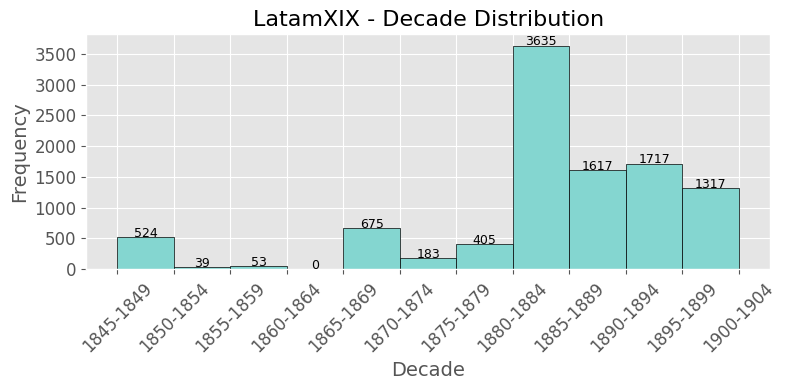

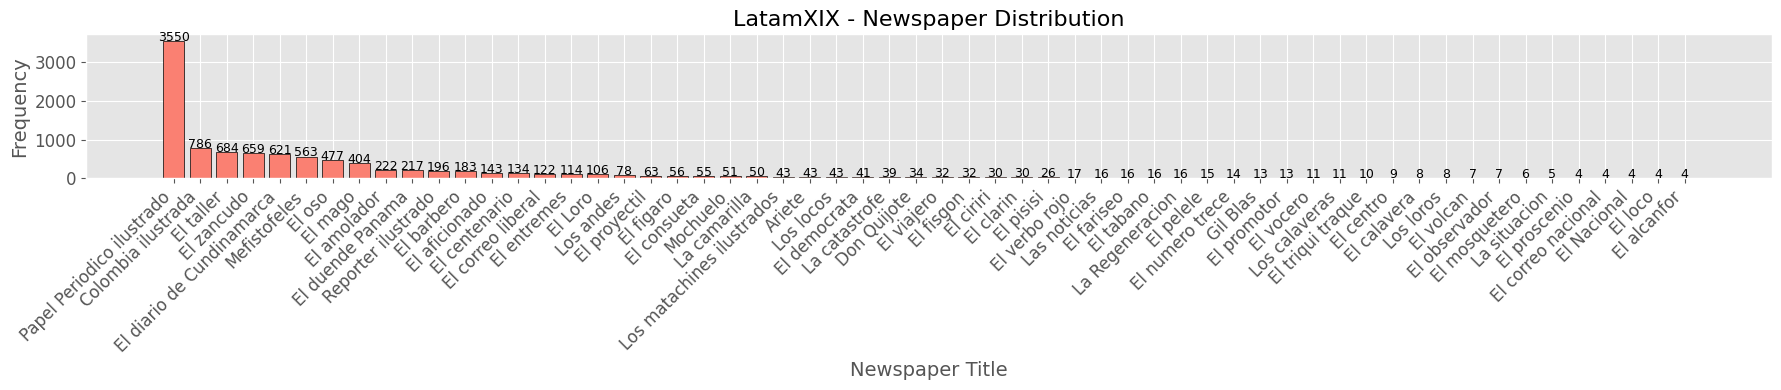

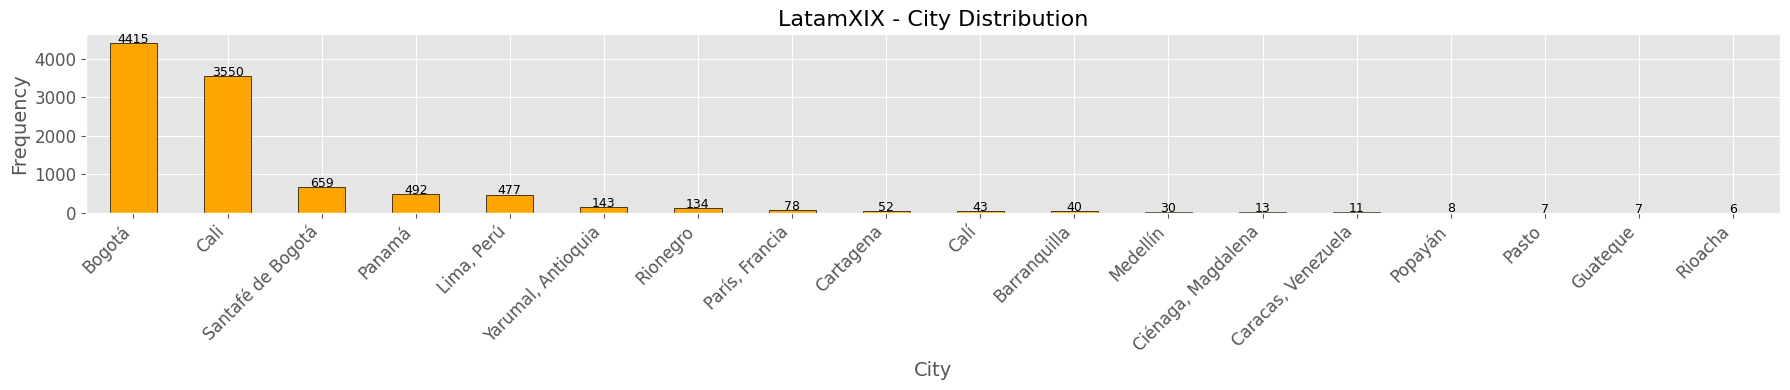

In [19]:
plt.style.use('ggplot')

# Histogram by Decade

min_year = df['year_low'].min()
max_year = df['year_low'].max()
bin_width = 5
num_bins = (max_year - min_year) // bin_width + 1
bins = np.linspace(min_year, min_year + (num_bins * bin_width), num_bins + 1)

plt.figure(figsize=(8, 4))
plt.hist(df['year_low'], bins=bins, edgecolor='black', align='mid', color='#84D6D0')
plt.title('LatamXIX - Decade Distribution', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=12)

plt.xticks(np.arange(min_year, max_year + bin_width, bin_width), [f'{int(year)}-{int(year+bin_width-1)}' for year in np.arange(min_year, max_year + bin_width, bin_width)], rotation=45, ha='center', fontsize=12)

for i, count in enumerate(np.histogram(df['year_low'], bins=bins)[0]):
    plt.text(bins[i]+2.5, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_years_histogram.png', dpi=300)
plt.show()

# Histogram by Newspaper Title

label_encoder = LabelEncoder()
df['title_label'] = label_encoder.fit_transform(df['title'])

title_counts = df['title_label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(18, 4))
plt.bar(range(len(title_counts)), title_counts.values, color='salmon', edgecolor='black')
plt.title('LatamXIX - Newspaper Distribution', fontsize=16)
plt.xlabel('Newspaper Title', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(len(title_counts)), label_encoder.inverse_transform(title_counts.index), rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(title_counts.values):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_titles_histogram.png', dpi=300)
plt.show()

# Histogram by City

plt.figure(figsize=(18, 4))
df['city'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('LatamXIX - City Distribution', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(df['city'].value_counts()):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_city_histogram.png', dpi=300)
plt.show()